In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from bluesky.plans import adaptive_scan, scan, tune_centroid
from bluesky.callbacks import LiveFit, LivePlot, LiveFitPlot, LiveTable
from bluesky.callbacks.fitting import PeakStats
from bluesky.callbacks.best_effort import BestEffortCallback as bec
from bluesky.preprocessors import subs_decorator
from bluesky import RunEngine
from ophyd.signal import EpicsSignalRO, EpicsSignal
from ophyd.epics_motor import EpicsMotor

#Need for testing/troubleshooting
from ophyd.sim import SynAxis, SynGauss, SynSignal

#For fitting
import lmfit
import numpy as np
import scipy
import math 

In [2]:
class SynErfGauss(SynSignal):
       
    def __init__(self, name, motor, motor_field, Imax, wid, x0,
                 noise=None, noise_multiplier=1, **kwargs):
        if noise not in ('poisson', 'uniform', None):
            raise ValueError("noise must be one of 'poisson', 'uniform', None")
        self._motor = motor

        def func():
            m = motor.read()[motor_field]['value']
            v = erfx(m, 0, Imax, wid, x0)
            v += gaussian(m, Imax*0.20, 0.1, x0 + 1 - wid/2.0 + 0.25*np.random.random())
            if noise == 'poisson':
                v = int(np.random.poisson(np.round(v), 1))
            elif noise == 'uniform':
                v += np.random.uniform(-1, 1) * noise_multiplier
            return v

        super().__init__(func=func, name=name, **kwargs)

In [3]:
def gaussian(x, A, sigma, x0):
    return A*np.exp(-(x - x0)**2/(2 * sigma**2))
    
def erfx(x, low, high, wid, x0):
    return (high - low) * 0.5 * (1-scipy.special.erf((x-x0)/wid)) + low   

In [4]:
fit_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
linestyles = ['-', '--', '-.', ':']

def_xAlignRange = [-1.00, 2.00]
def_xStepRange = [0.0015, 0.1]
def_xTargetDelta = 0.0025
def_fudge = 0.75
def_thAlignRange = [4.0,6.0]
def_thCoarseStep = 0.1 
def_thFineRadius = 0.2 
def_thStepRange = [0.015, 0.1]	#min thMotor step is 0.01 degrees
def_thTargetDelta = 0.1

In [5]:
try:
    thAlignRange = theta_kws['alignRange'] 
except:
    thAlignRange = def_thAlignRange 

In [6]:
xMotor = SynAxis(name='xMotor')
simX0 = np.random.random()-0.5
thMotor = SynAxis(name='thMotor')
simCenter = (thAlignRange[1]-thAlignRange[0])*np.random.random() + thAlignRange[0]
detTh = SynGauss('detTh',thMotor, 'thMotor', center=simCenter, Imax=1, sigma=.03, noise='uniform', noise_multiplier=0.05)
detX = SynErfGauss('detX', xMotor, 'xMotor', Imax=0.024, wid=0.20, x0 = simX0, noise='uniform', noise_multiplier=0.0005)

In [21]:
RE = RunEngine({})

<IPython.core.display.Javascript object>


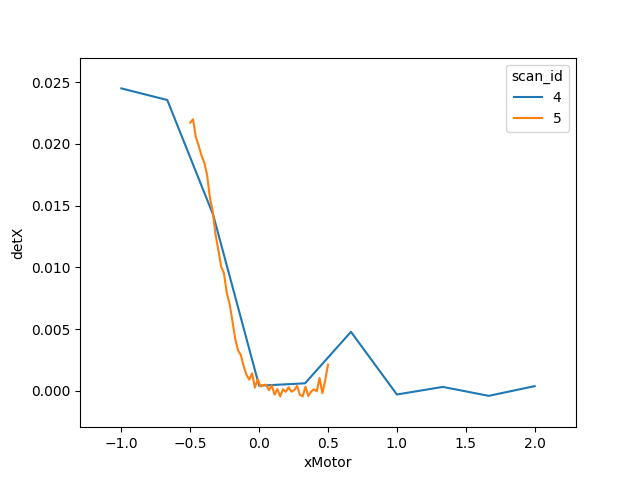

In [34]:
xLivePlot = LivePlot('detX',x='xMotor')
xLiveTable = LiveTable([detX, xMotor])

xCbs = [xLivePlot, xLiveTable]

In [35]:
@subs_decorator(xCbs)
def multiScan(detectors, motor, fRange = [-0.5, 0.5], cRange = [-1.0, 2.0], coarse=10, fine=50):
    yield from scan(detectors, motor, cRange[0], cRange[1], num = coarse)
    yield from scan(detectors, motor, fRange[0], fRange[1], num = fine)

In [36]:
RE(multiScan([detX], xMotor))

+-----------+------------+------------+------------+-----------------+
|   seq_num |       time |       detX |     xMotor | xMotor_setpoint |
+-----------+------------+------------+------------+-----------------+
|         1 | 17:04:09.9 |      0.024 |     -1.000 |          -1.000 |
|         2 | 17:04:09.9 |      0.024 |     -0.667 |          -0.667 |
|         3 | 17:04:09.9 |      0.014 |     -0.333 |          -0.333 |
|         4 | 17:04:09.9 |      0.000 |      0.000 |           0.000 |
|         5 | 17:04:10.0 |      0.001 |      0.333 |           0.333 |
|         6 | 17:04:10.0 |      0.005 |      0.667 |           0.667 |
|         7 | 17:04:10.0 |     -0.000 |      1.000 |           1.000 |
|         8 | 17:04:10.0 |      0.000 |      1.333 |           1.333 |
|         9 | 17:04:10.0 |     -0.000 |      1.667 |           1.667 |
|        10 | 17:04:10.1 |      0.000 |      2.000 |           2.000 |
+-----------+------------+------------+------------+-----------------+
genera

('998c5cca-bbf5-4863-bf8b-80540c8da3f7',
 '6e3ae95d-d1dc-420f-b18a-861672c3719b')

### Simple Coarse/Fine scan with plots

<IPython.core.display.Javascript object>


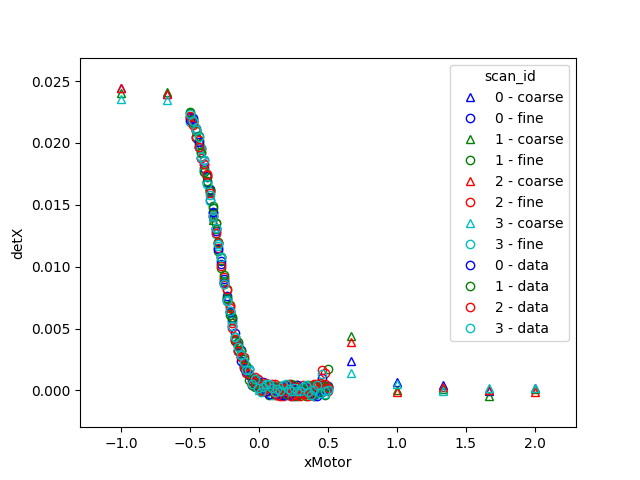

In [57]:
fix, ax = plt.subplots()

@subs_decorator(xLiveTable)
def multiScan(iter_count, detectors, motor, fRange = [-0.5, 0.5], cRange = [-1.0, 2.0], coarse=10, fine=50):
    for iteration in np.arange(iter_count):
        cur_color = fit_colors[iteration % len(fit_colors)]
        finePlot = LivePlot('detX',x='xMotor', markeredgecolor = cur_color, markerfacecolor = 'none', 
                            ax = ax, linestyle = 'none', marker = 'o', label = '{} - fine'.format(iteration))
        coarsePlot = LivePlot('detX',x='xMotor', linestyle = 'none', marker = '^', markerfacecolor = 'none',
                              markeredgecolor = cur_color, ax = ax, label = '{} - coarse'.format(iteration))
        
        @subs_decorator(coarsePlot)
        def coarseScan(detectors, motor, cRange, pts = 10):
            yield from scan(detectors, motor, cRange[0], cRange[1], num = pts)
    
        @subs_decorator(finePlot)
        def fineScan(detectors, motor, fRange, pts = 50):
            yield from scan(detectors, motor, fRange[0], fRange[1], num = pts)

        yield from coarseScan(detectors, motor, cRange, pts = coarse)
        yield from fineScan(detectors, motor, fRange, pts = fine)

In [58]:
RE(multiScan(4, [detX], xMotor))

+-----------+------------+------------+------------+-----------------+
|   seq_num |       time |       detX |     xMotor | xMotor_setpoint |
+-----------+------------+------------+------------+-----------------+
|         1 | 17:30:01.3 |      0.024 |     -1.000 |          -1.000 |
|         2 | 17:30:01.3 |      0.024 |     -0.667 |          -0.667 |
|         3 | 17:30:01.3 |      0.014 |     -0.333 |          -0.333 |
|         4 | 17:30:01.4 |      0.000 |      0.000 |           0.000 |
|         5 | 17:30:01.4 |     -0.000 |      0.333 |           0.333 |
|         6 | 17:30:01.4 |      0.002 |      0.667 |           0.667 |
|         7 | 17:30:01.4 |      0.001 |      1.000 |           1.000 |
|         8 | 17:30:01.4 |      0.000 |      1.333 |           1.333 |
|         9 | 17:30:01.4 |     -0.000 |      1.667 |           1.667 |
|        10 | 17:30:01.4 |      0.000 |      2.000 |           2.000 |
+-----------+------------+------------+------------+-----------------+
genera

|        31 | 17:30:03.6 |     -0.000 |      0.112 |           0.112 |
|        32 | 17:30:03.7 |     -0.000 |      0.133 |           0.133 |
|        33 | 17:30:03.7 |      0.000 |      0.153 |           0.153 |
|        34 | 17:30:03.7 |     -0.000 |      0.173 |           0.173 |
|        35 | 17:30:03.7 |      0.000 |      0.194 |           0.194 |
|        36 | 17:30:03.7 |      0.000 |      0.214 |           0.214 |
|        37 | 17:30:03.8 |      0.000 |      0.235 |           0.235 |
|        38 | 17:30:03.8 |     -0.000 |      0.255 |           0.255 |
|        39 | 17:30:03.8 |     -0.000 |      0.276 |           0.276 |
|        40 | 17:30:03.8 |     -0.000 |      0.296 |           0.296 |
|        41 | 17:30:03.8 |     -0.000 |      0.316 |           0.316 |
|        42 | 17:30:03.8 |     -0.000 |      0.337 |           0.337 |
|        43 | 17:30:03.9 |     -0.000 |      0.357 |           0.357 |
|        44 | 17:30:03.9 |     -0.000 |      0.378 |           0.378 |
|     

|        16 | 17:30:06.7 |      0.006 |     -0.194 |          -0.194 |
|        17 | 17:30:06.7 |      0.004 |     -0.173 |          -0.173 |
|        18 | 17:30:06.7 |      0.004 |     -0.153 |          -0.153 |
|        19 | 17:30:06.7 |      0.003 |     -0.133 |          -0.133 |
|        20 | 17:30:06.7 |      0.002 |     -0.112 |          -0.112 |
|        21 | 17:30:06.7 |      0.002 |     -0.092 |          -0.092 |
|        22 | 17:30:06.8 |      0.002 |     -0.071 |          -0.071 |
|        23 | 17:30:06.8 |      0.001 |     -0.051 |          -0.051 |
|        24 | 17:30:06.8 |      0.001 |     -0.031 |          -0.031 |
|        25 | 17:30:06.8 |      0.001 |     -0.010 |          -0.010 |
|        26 | 17:30:06.8 |      0.001 |      0.010 |           0.010 |
|        27 | 17:30:06.8 |      0.000 |      0.031 |           0.031 |
|        28 | 17:30:06.8 |      0.000 |      0.051 |           0.051 |
|        29 | 17:30:06.9 |      0.000 |      0.071 |           0.071 |
|     

('8efc1c43-fb64-4fda-a6e8-5b03e3969169',
 '927500cc-e69f-4b68-af8a-f44b77ecebad',
 'ca8ee159-aae2-44b8-a0f6-5c71912213f4',
 'dfb2b0ea-5abf-4812-bfec-3b504a25b89e',
 '214f12e0-11ee-4b3d-ac9d-5e74a67b027c',
 '94fbc047-f8bd-45c6-a377-4bd64334226e',
 'fc211abf-29c5-4ed1-9882-cc3bbce0ea8f',
 '350084cc-9048-4fd7-9d41-11d21a4e2c55')

### Simple Scan with Fit after the fact and return of centroid
The following code doesn't seem significantly cleaner then the earlier code

<IPython.core.display.Javascript object>


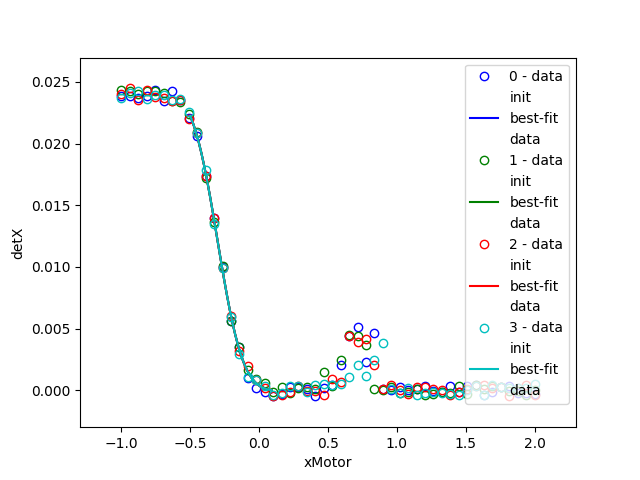

In [73]:
fig2, bx = plt.subplots()

def fitAndPlotBumplessData(y, x, x0, width, fudge = 0.5, ax = ax, color = 'r', linestyle = '-'): 
    x_reduced_max = x0 + fudge - 0.5*width

    xdata = np.asarray(x)
    ydata = np.asarray(y)
    ix = np.where(xdata < x_reduced_max)

    x_reduced = xdata[ix]
    y_reduced = ydata[ix]

    red_model = lmfit.Model(erfx, missing = 'drop')
    red_guess = {'low': min(y_reduced),
                 'high': max(y_reduced),
                 'wid': lmfit.Parameter('wid', value = width, min=0),
                 'x0': x0}

    params = red_model.make_params(low = min(y_reduced), high = max(y_reduced), 
                                   wid = width, x0 = x0)

    redFit = red_model.fit(y_reduced, params, x = x_reduced)
    redFit_x0 = redFit.result.params['x0'].value
    redFit_width = redFit.result.params['wid'].value

    #plot new fit
    redFit.plot_fit(ax = ax, data_kws = {'visible':False}, 
                    fit_kws={'color': color, 
                             'linestyle' : linestyle},
                    init_kws={'visible':False},
                    xlabel = 'xMotor', ylabel = 'detX')
    ax.set_title(' ')

    return redFit_x0


@subs_decorator(xLiveTable)
def ScanThenFit(iter_count, detector, det_name, motor, motor_name, fRange = [-1, 2], cRange = [-1.0, 2.0], pts = 50):
    for iteration in np.arange(iter_count):
        cur_color = fit_colors[iteration % len(fit_colors)]
        cur_linestyle = linestyles[iteration // len(fit_colors)]

        scanPlot = LivePlot('detX',x='xMotor', markeredgecolor = cur_color, markerfacecolor = 'none', 
                            ax = bx, linestyle = 'none', marker = 'o', label = '{} - data'.format(iteration))
        
        comp_model = lmfit.Model(erfx, prefix="erf_") + lmfit.Model(gaussian, prefix = "gau_")
        comp_guess = {'erf_low': 0,
                      'erf_high': 0.03,
                      'erf_wid': lmfit.Parameter('erf_wid', value = 0.4, min=0),
                      'erf_x0': -0.1,
                      'gau_A': 0.01,
                      'gau_sigma': lmfit.Parameter('gau_sigma', value = .1, min=0),
                      'gau_x0': 1.0}
        xLiveFit = LiveFit(comp_model, det_name, {'x': motor_name}, comp_guess, update_every=5)
                
        @subs_decorator([scanPlot, xLiveFit])
        def preFitScan(detectors, motor, fRange, pts = 50):
            yield from scan(detectors, motor, fRange[0], fRange[1], num = pts)

        yield from preFitScan(detector, motor, fRange)

        x0_rough = xLiveFit.result.params['erf_x0'].value
        width = xLiveFit.result.params['erf_wid'].value
        
        x0 = fitAndPlotBumplessData(np.asarray(finePlot.y_data), np.asarray(finePlot.x_data), x0_rough, width,
                               ax = bx, color = cur_color, linestyle = cur_linestyle)
        print(x0)
        

In [74]:
RE(ScanThenFit(4, [detX], 'detX', xMotor, 'xMotor'))

+-----------+------------+------------+------------+-----------------+
|   seq_num |       time |       detX |     xMotor | xMotor_setpoint |
+-----------+------------+------------+------------+-----------------+
|         1 | 18:06:37.8 |      0.024 |     -1.000 |          -1.000 |
|         2 | 18:06:37.8 |      0.024 |     -0.939 |          -0.939 |
|         3 | 18:06:37.9 |      0.024 |     -0.878 |          -0.878 |
|         4 | 18:06:37.9 |      0.024 |     -0.816 |          -0.816 |
|         5 | 18:06:37.9 |      0.024 |     -0.755 |          -0.755 |
|         6 | 18:06:37.9 |      0.023 |     -0.694 |          -0.694 |
|         7 | 18:06:37.9 |      0.024 |     -0.633 |          -0.633 |
|         8 | 18:06:38.0 |      0.024 |     -0.571 |          -0.571 |
|         9 | 18:06:38.0 |      0.022 |     -0.510 |          -0.510 |
|        10 | 18:06:38.0 |      0.021 |     -0.449 |          -0.449 |
|        11 | 18:06:38.1 |      0.017 |     -0.388 |          -0.388 |
|     

|         8 | 18:06:41.6 |      0.024 |     -0.571 |          -0.571 |
|         9 | 18:06:41.6 |      0.022 |     -0.510 |          -0.510 |
|        10 | 18:06:41.6 |      0.021 |     -0.449 |          -0.449 |
|        11 | 18:06:41.6 |      0.017 |     -0.388 |          -0.388 |
|        12 | 18:06:41.8 |      0.014 |     -0.327 |          -0.327 |
|        13 | 18:06:41.8 |      0.010 |     -0.265 |          -0.265 |
|        14 | 18:06:41.8 |      0.006 |     -0.204 |          -0.204 |
|        15 | 18:06:41.8 |      0.003 |     -0.143 |          -0.143 |
|        16 | 18:06:41.8 |      0.002 |     -0.082 |          -0.082 |
|        17 | 18:06:41.9 |      0.001 |     -0.020 |          -0.020 |
|        18 | 18:06:41.9 |      0.000 |      0.041 |           0.041 |
|        19 | 18:06:41.9 |     -0.000 |      0.102 |           0.102 |
|        20 | 18:06:41.9 |     -0.000 |      0.163 |           0.163 |
|        21 | 18:06:41.9 |     -0.000 |      0.224 |           0.224 |
|     

('381b745f-ccf2-46bf-a1ec-c0f9bc9a3340',
 '21775873-b714-4f91-9923-e31c79d3363e',
 '1c8c91d5-a023-4d33-a866-b8aeb5288382',
 '49b943ad-5a60-4ad7-a645-c923eaff9652')

### Simple Scan with Fit after the fact, return of inflection, make inflection available for next scan (xScan)


### AdaptiveScan with Fit after the fact and return of inflection (xScan)


### Trying Tune Centroid (thetaScan)

In [17]:
RE = RunEngine({})

<IPython.core.display.Javascript object>


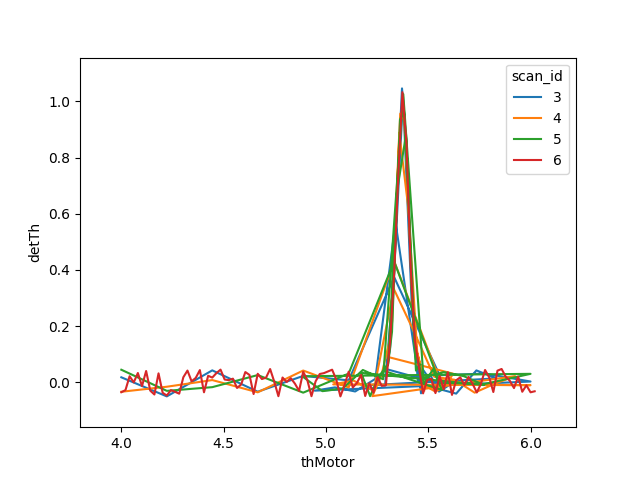

In [11]:
thLivePlot = LivePlot('detTh',x='thMotor')
thLiveTable = LiveTable([detTh, thMotor])
thCbs = [thLivePlot, thLiveTable]

In [15]:
print(simCenter)
RE(tune_centroid([detTh],'detTh',thMotor, 4, 6, 0.01, 100), thCbs)

5.3744335321808565
+-----------+------------+------------+------------+------------------+
|   seq_num |       time |      detTh |    thMotor | thMotor_setpoint |
+-----------+------------+------------+------------+------------------+
|         1 | 12:36:50.8 |     -0.035 |      4.000 |            4.000 |
|         2 | 12:36:50.8 |     -0.027 |      4.020 |            4.020 |
|         3 | 12:36:50.9 |      0.022 |      4.040 |            4.040 |
|         4 | 12:36:50.9 |      0.000 |      4.061 |            4.061 |
|         5 | 12:36:50.9 |      0.034 |      4.081 |            4.081 |
|         6 | 12:36:50.9 |     -0.013 |      4.101 |            4.101 |
|         7 | 12:36:50.9 |      0.041 |      4.121 |            4.121 |
|         8 | 12:36:50.9 |     -0.029 |      4.141 |            4.141 |
|         9 | 12:36:51.0 |     -0.043 |      4.162 |            4.162 |
|        10 | 12:36:51.0 |      0.032 |      4.182 |            4.182 |
|        11 | 12:36:51.0 |     -0.037 |      

('b6580430-a851-45de-98a7-22023852870a',)

Tune Centroid won't due to small back step (< 1 degree)

### Coarse scan with max return + fine (adaptive scan) about peak (thetaScan)

In [18]:
RE = RunEngine({})

In [19]:
thLiveTable = LiveTable([detTh, thMotor])

<IPython.core.display.Javascript object>


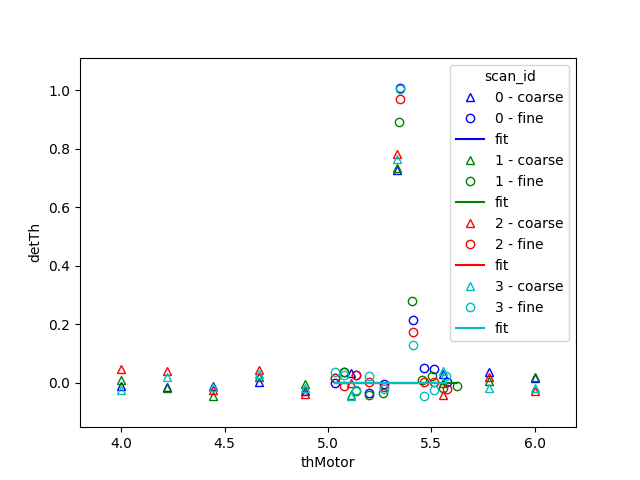

In [26]:
fix, dx = plt.subplots()


@subs_decorator(thLiveTable)
def multiScan(iter_count, detectors, motor, fRange = [4, 6], cRange = [4, 6], coarse=10, fineRadius=0.3, 
             fStepRange = [0.01, 0.1]):
    for iteration in np.arange(iter_count):
        cur_color = fit_colors[iteration % len(fit_colors)]
        finePlot = LivePlot('detTh',x='thMotor', markeredgecolor = cur_color, markerfacecolor = 'none', 
                            ax = dx, linestyle = 'none', marker = 'o', label = '{} - fine'.format(iteration))
        coarsePlot = LivePlot('detTh',x='thMotor', linestyle = 'none', marker = '^', markerfacecolor = 'none',
                              markeredgecolor = cur_color, ax = dx, label = '{} - coarse'.format(iteration))
        coarsePeak = PeakStats('thMotor','detTh')

        @subs_decorator([coarsePlot,coarsePeak])
        def coarseScan(detectors, motor, cRange, pts = 10):
            yield from scan(detectors, motor, cRange[0], cRange[1], num = pts)
        
        yield from coarseScan(detectors, motor, cRange, pts = coarse)

        finePlot = LivePlot('detTh',x='thMotor', linestyle = 'none', marker = 'o', markerfacecolor = 'none',
                              markeredgecolor = cur_color, ax = dx, label = '{} - fine'.format(iteration))
        fineThetaModel = lmfit.Model(gaussian)
        fineThetaInitGuess = {'A': 1, 
                              'sigma': lmfit.Parameter('sigma', .03, min=0),
                              'x0': coarsePeak.max[1]}
        fineThetaLiveFit = LiveFit(fineThetaModel, 'detTh', {'x': 'thMotor'}, fineThetaInitGuess, update_every=1)
        fineThetaLiveFitPlot = LiveFitPlot(fineThetaLiveFit, ax = dx, label='fit', color = fit_colors[iteration % 7],
                                       linestyle = linestyles[iteration // 7])
        
        fRange = [coarsePeak.max[0]-fineRadius, coarsePeak.max[0]+fineRadius]
      
        @subs_decorator([finePlot,fineThetaLiveFitPlot])
        def fineScan(detectors, motor, fRange, pts = 50):
            yield from adaptive_scan(detectors, 'detTh', motor, start = fRange[0], stop = fRange[1], 
                                     min_step = fStepRange[0], max_step = fStepRange[1], 
                                     target_delta = def_thTargetDelta, backstep = False)
    
        yield from fineScan(detectors, motor, fRange)

In [27]:
RE(multiScan(4, [detTh], thMotor))

+-----------+------------+------------+------------+------------------+
|   seq_num |       time |      detTh |    thMotor | thMotor_setpoint |
+-----------+------------+------------+------------+------------------+
|         1 | 09:58:28.7 |     -0.013 |      4.000 |            4.000 |
|         2 | 09:58:28.8 |     -0.013 |      4.222 |            4.222 |
|         3 | 09:58:28.8 |     -0.012 |      4.444 |            4.444 |
|         4 | 09:58:28.8 |      0.001 |      4.667 |            4.667 |
|         5 | 09:58:28.8 |     -0.028 |      4.889 |            4.889 |
|         6 | 09:58:28.8 |      0.034 |      5.111 |            5.111 |
|         7 | 09:58:28.8 |      0.728 |      5.333 |            5.333 |
|         8 | 09:58:28.9 |      0.029 |      5.556 |            5.556 |
|         9 | 09:58:28.9 |      0.037 |      5.778 |            5.778 |
|        10 | 09:58:28.9 |      0.017 |      6.000 |            6.000 |
+-----------+------------+------------+------------+------------

|         9 | 09:58:32.6 |     -0.025 |      5.514 |            5.514 |
|        10 | 09:58:32.6 |      0.024 |      5.573 |            5.573 |
+-----------+------------+------------+------------+------------------+
generator adaptive_scan ['153a2c'] (scan num: 32)


('82d2d80a-cb6e-4113-a1f3-3915fcc71f85',
 '3bf1a86c-066a-4f10-90ab-96609d7e5b82',
 '6ad7dfd3-a030-489f-b39d-71b574c77844',
 'ad5d867f-bcb9-424d-b1c5-15d254354e3f',
 '7a552915-8b25-403d-9183-0043338ef767',
 '71291d8f-e287-46eb-99bb-69924617794f',
 '2a5d38d1-b935-4714-9d8f-19471307ddd7',
 '153a2c40-cc31-430c-84d8-ba77c4e66b4e')

### Coarse scan with max return + fine (adaptive scan) about peak + return peak location (thetaScan)